SCPY562 Modeling and Simulation in Biophysics - Mini Project

Code II : Bayesian Inference + Gillespie Algorithm

Modified by Mr. Pasin Kiratipongwut ID 6737983

cell 1

In [87]:
import matplotlib
import operator
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib

from google.colab import drive
drive.mount('/content/drive')

import os
# adjust this path if your folder is elsewhere
workspace_path = '/content/drive/My Drive/MU Workspace/SCPY562 Modeling and Simulation in Biophysics/mini_proj'
os.chdir(workspace_path)

import sys
sys.path.append('/content/drive/My Drive/MU Workspace/SCPY562 Modeling and Simulation in Biophysics/mini_proj')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
import os

for root, dirs, files in os.walk('/content/drive/My Drive/MU Workspace/', topdown=True):
    for f in files:
        if '80_dataset_with_fixed_cycles' in f:
            print(os.path.join(root, f))


/content/drive/My Drive/MU Workspace/SCPY562 Modeling and Simulation in Biophysics/mini_proj/edited_80.0/image_analysis_ovary/80_dataset_with_fixed_cycles.csv
/content/drive/My Drive/MU Workspace/SCPY562 Modeling and Simulation in Biophysics/mini_proj/edited_80.0/image_analysis_ovary/80_dataset_with_fixed_cycles.gsheet


In [89]:
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
from random import sample

# Load your data
file_path = '/content/drive/My Drive/MU Workspace/SCPY562 Modeling and Simulation in Biophysics/mini_proj/edited_80.0/image_analysis_ovary/80_dataset_with_fixed_cycles.csv'
data = pd.read_csv(file_path)

#data = data[data['Peptide Ratio'] == '80_background_edit']

cell 2

In [90]:
# Extract necessary data
efp_in = data['EFP_in%'].values
ee = data['Endosomal Escape%'].values
inc_efp_in = np.diff(efp_in) / 5
inc_ee = np.diff(ee) / 5
inc_efp_out = inc_efp_in - inc_ee
n_steps = len(inc_efp_in)

# Define the Bayesian hierarchical model
with pm.Model() as hierarchical_model:
    # Global hyperpriors
    global_mu = pm.Cauchy("global_mu", alpha=0.3255936 , beta=0.218884)
    global_sigma = pm.Cauchy("global_sigma", alpha=0.2383414 , beta=0.1373218 )
    global_dexit =  pm.Normal("global_dexit", mu=0.03666491, sigma=0.1)

    # Local priors for each time step
    mu = pm.Normal("mu", mu=global_mu, sigma=0.1, shape=n_steps)
    sigma = pm.Normal("sigma", mu=global_sigma, sigma=0.1, shape=n_steps)
    dexit = pm.Normal("dexit", mu=global_dexit, sigma=0.1, shape=n_steps)

    # Likelihoods for the observed increments
    likelihood_efp_in = pm.Normal("likelihood_efp_in", mu=mu, sigma=0.3, observed=inc_efp_in)
    likelihood_ee = pm.Normal("likelihood_ee", mu=sigma, sigma=0.3, observed=inc_ee)
    likelihood_efp_out = pm.Normal("likelihood_efp_out", mu=dexit, sigma=0.2, observed=inc_efp_out)

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, target_accept=0.9, chains=5)

# Extract posterior means for each time step
mu_estimates = trace.posterior["mu"].mean(dim=["chain", "draw"]).values
sigma_estimates = trace.posterior["sigma"].mean(dim=["chain", "draw"]).values
dexit_estimates = trace.posterior["dexit"].mean(dim=["chain", "draw"]).values

Output()

cell 3

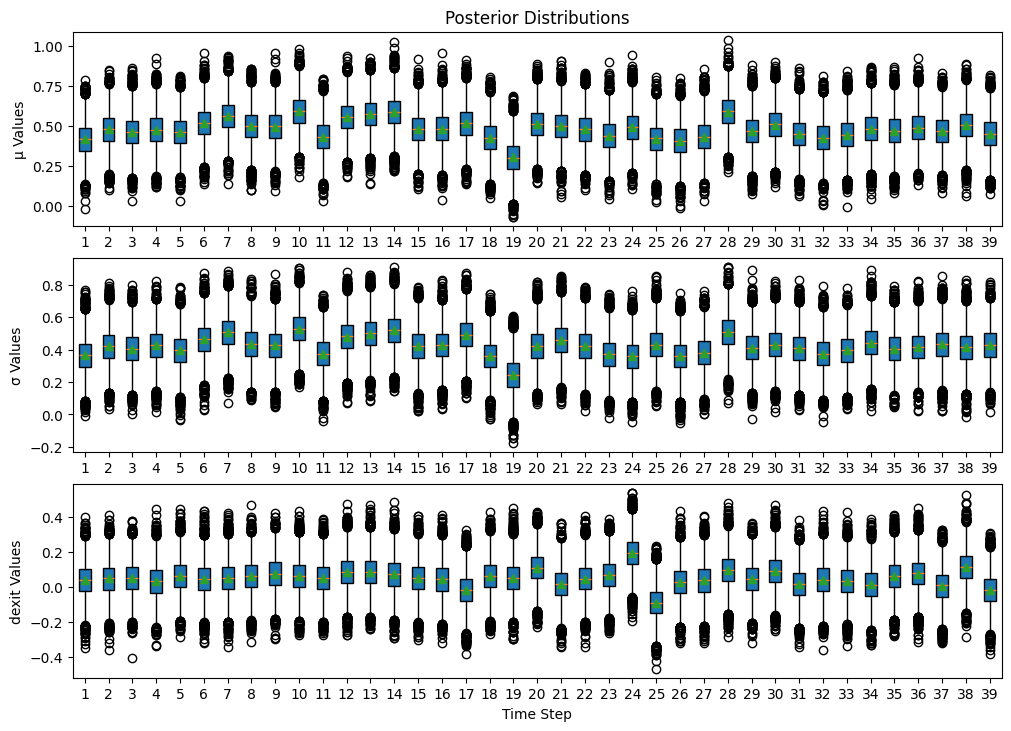

In [91]:
import matplotlib.pyplot as plt
import arviz as az
import numpy as np

# Extract posterior samples for each parameter
mu_samples = trace.posterior["mu"].stack(samples=("chain", "draw")).values
sigma_samples = trace.posterior["sigma"].stack(samples=("chain", "draw")).values
dexit_samples = trace.posterior["dexit"].stack(samples=("chain", "draw")).values

# Number of time steps
n_steps = mu_samples.shape[0]

# Create box-whisker plots for each parameter
fig, axes = plt.subplots(3, 1, figsize=(10, 7.2), constrained_layout=True)

# Plot for mu
axes[0].boxplot(mu_samples.T, vert=True, patch_artist=True, showmeans=True)
#axes[0].set_title("Posterior Distributions of μ per time step")
axes[0].set_title("Posterior Distributions")
#axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("μ Values")
axes[0].set_xticks(range(1, n_steps + 1))
axes[0].set_xticklabels(range(1, n_steps + 1))

# Plot for sigma
axes[1].boxplot(sigma_samples.T, vert=True, patch_artist=True, showmeans=True)
#axes[1].set_title("Posterior Distributions of σ per time step")
#axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("σ Values")
axes[1].set_xticks(range(1, n_steps + 1))
axes[1].set_xticklabels(range(1, n_steps + 1))

# Plot for dexit
axes[2].boxplot(dexit_samples.T, vert=True, patch_artist=True, showmeans=True)
#axes[2].set_title("Posterior Distributions of dexit per time step")
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("dexit Values")
axes[2].set_xticks(range(1, n_steps + 1))
axes[2].set_xticklabels(range(1, n_steps + 1))

# Show the plots
plt.show()


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
dexit[0],0.037,0.095,-0.141,0.215,0.001,0.001,13666.0,6185.0,1.0
dexit[1],0.047,0.093,-0.126,0.221,0.001,0.001,12108.0,7080.0,1.0
dexit[2],0.050,0.093,-0.120,0.226,0.001,0.001,12305.0,7225.0,1.0
dexit[3],0.032,0.095,-0.147,0.203,0.001,0.001,10529.0,6590.0,1.0
dexit[4],0.061,0.094,-0.108,0.245,0.001,0.001,13227.0,7191.0,1.0
...,...,...,...,...,...,...,...,...,...
sigma[34],0.405,0.106,0.212,0.609,0.001,0.001,5472.0,6622.0,1.0
sigma[35],0.417,0.104,0.224,0.615,0.001,0.001,4932.0,6831.0,1.0
sigma[36],0.432,0.106,0.241,0.639,0.001,0.001,5140.0,5733.0,1.0
sigma[37],0.414,0.106,0.205,0.603,0.001,0.001,5116.0,5878.0,1.0


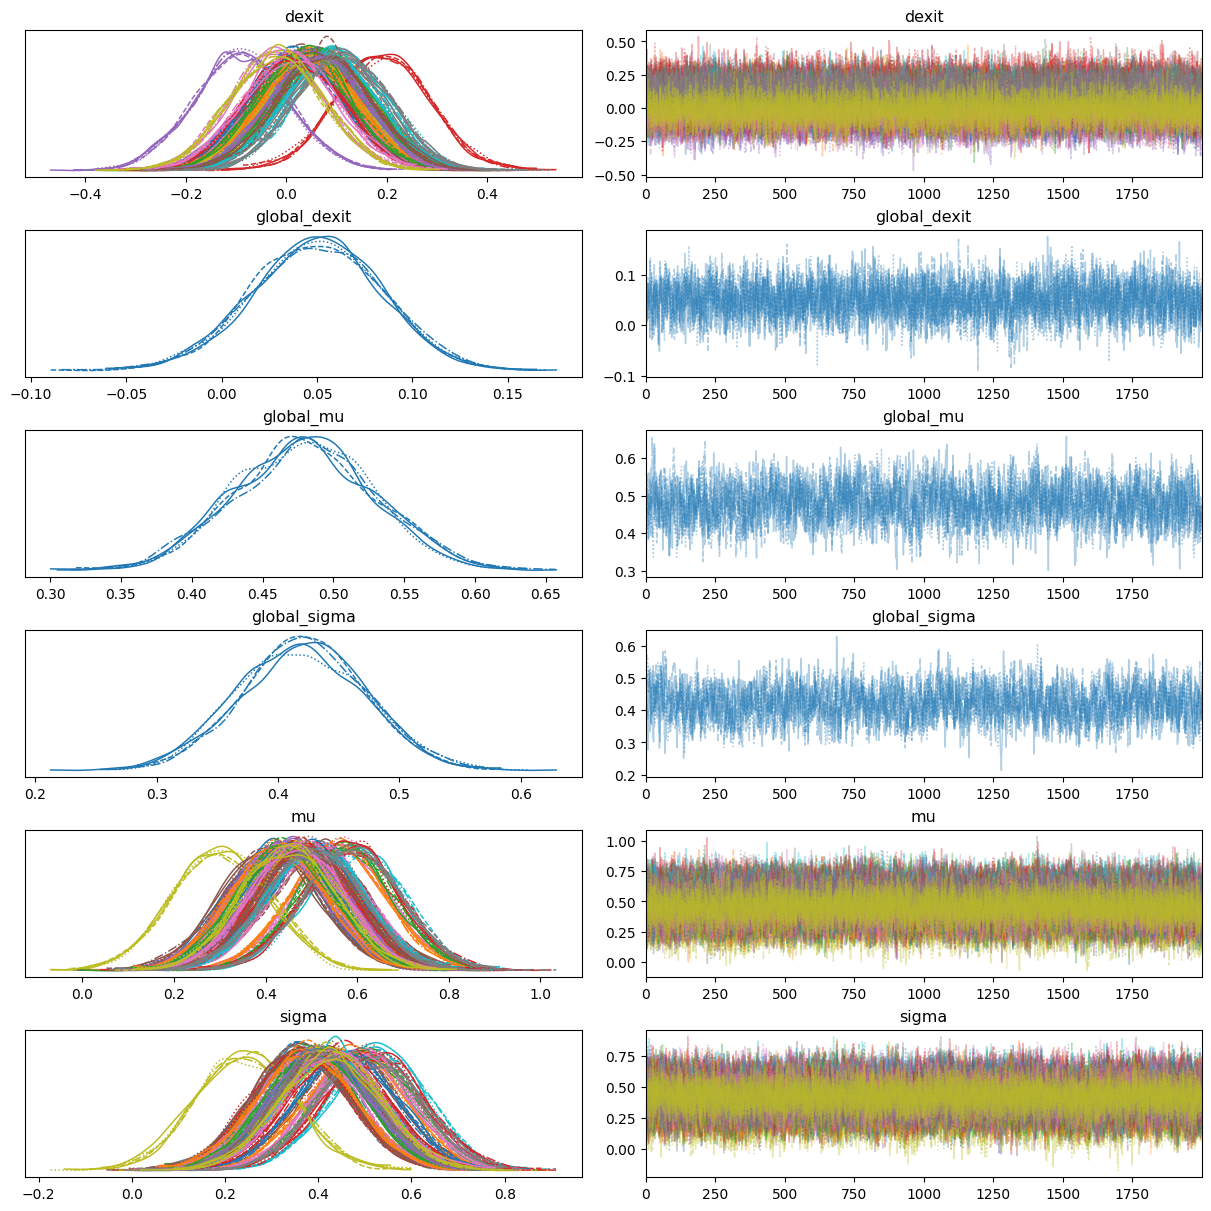

In [92]:
plt.rcParams['figure.constrained_layout.use'] = True
az.plot_trace(trace)
az.summary(trace)

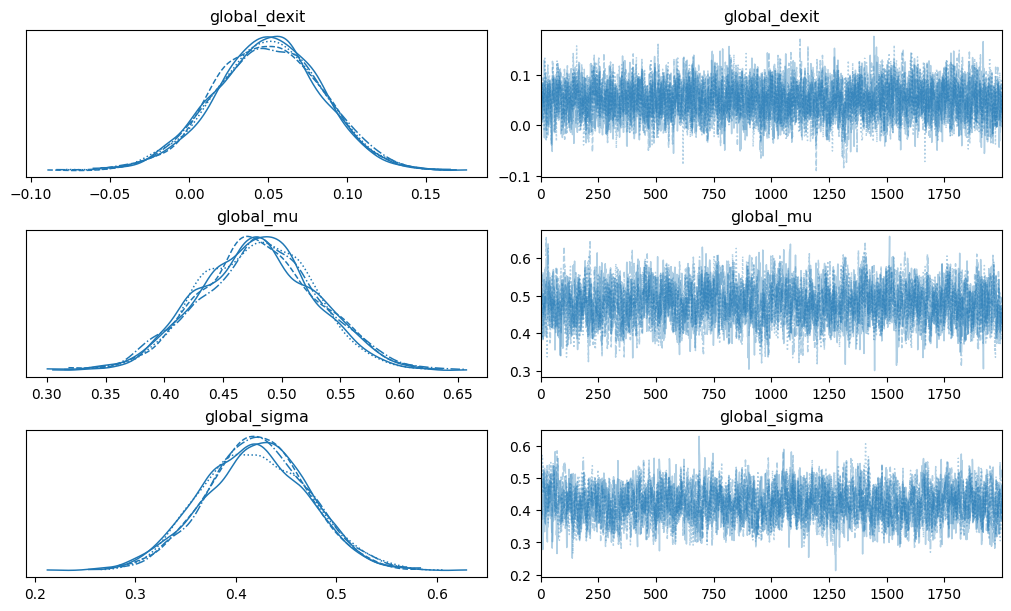

In [93]:
import arviz as az
import matplotlib.pyplot as plt

# เลือกเฉพาะ global parameters
az.plot_trace(
    trace,
    var_names=["global_dexit", "global_mu", "global_sigma"],
    figsize=(10, 6),
)
plt.show()


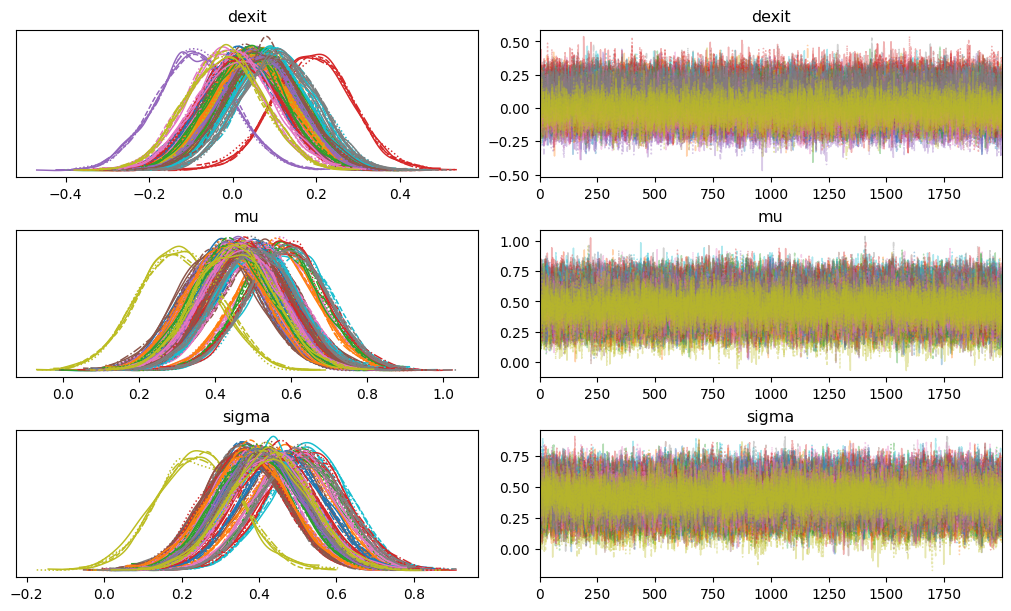

In [94]:
import arviz as az
import matplotlib.pyplot as plt

az.plot_trace(
    trace,
    var_names=["dexit", "mu", "sigma"],
    figsize=(10, 6),
)
plt.show()

cell 4

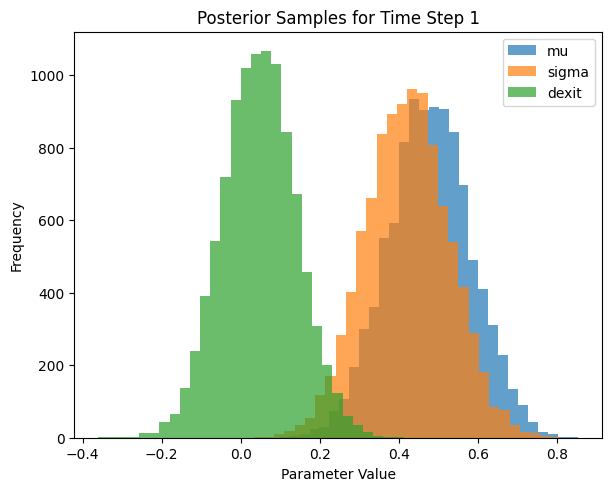

In [95]:
# Extract posterior samples for each time step
posterior_samples = trace.posterior

# Number of samples to draw for each time step
n_samples = 10000  # Adjust this number as needed

# Initialize lists to store sampled rates for each parameter
mu_samples = []
sigma_samples = []
dexit_samples = []

# Iterate over each time step
for t in range(n_steps):
    # Extract samples for the current time step
    mu_t_samples = posterior_samples["mu"][:, :, t].values.flatten()
    sigma_t_samples = posterior_samples["sigma"][:, :, t].values.flatten()
    dexit_t_samples = posterior_samples["dexit"][:, :, t].values.flatten()

    # Randomly sample from the posterior distribution at time t
    mu_samples.append(sample(list(mu_t_samples), n_samples))
    sigma_samples.append(sample(list(sigma_t_samples), n_samples))
    dexit_samples.append(sample(list(dexit_t_samples), n_samples))

# Convert lists to NumPy arrays for further analysis or visualization
mu_samples = np.array(mu_samples)
sigma_samples = np.array(sigma_samples)
dexit_samples = np.array(dexit_samples)

# Example: Plot posterior samples for a specific time step
time_step = 1  # Choose a time step to visualize
plt.figure(figsize=(6, 4.8))
plt.hist(mu_samples[time_step], bins=30, alpha=0.7, label="mu")
plt.hist(sigma_samples[time_step], bins=30, alpha=0.7, label="sigma")
plt.hist(dexit_samples[time_step], bins=30, alpha=0.7, label="dexit")
plt.title(f"Posterior Samples for Time Step {time_step}")
plt.xlabel("Parameter Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


cell 5

In [96]:
tf = 4
tstep = n_steps
beta = 0.000
peptide_ratio = 80  # Set the peptide ratio directly
ratio_exp = 6.892
fixed_siRNA_amount = 120

exp_value = ratio_exp
initial_FP = exp_value * fixed_siRNA_amount

initial_conditions = np.array([
                  initial_FP-fixed_siRNA_amount,
                    0,
                    100-efp_in[0] ,
                    ee[0] *fixed_siRNA_amount/100 ,
                  (efp_in[0] - ee[0])*fixed_siRNA_amount/100
] , dtype=float)

print(initial_conditions)

[7.07040000e+02 0.00000000e+00 9.55554024e+01 4.67199559e+00
 6.61521499e-01]


cell 6

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def gillespie_extended_with_posteriors(
    mu_estimates, sigma_estimates, dexit_estimates,
    initial_state, t_max, t_points
):
    A, B, C, D, E = initial_state

    times = [0]
    states = [[A, B, C, D, E]]

    while times[-1] < t_max:
        # Find the closest time step index for posterior parameters
        t_idx = np.searchsorted(t_points, times[-1], side="right") - 1

        # Use the posterior means for the current time step
        mu = mu_estimates[t_idx]
        sigma = sigma_estimates[t_idx]
        dexit = dexit_estimates[t_idx]

        # Reaction rates
        rates = [
            mu * A * B,  # A + B -> C
            0 * B,       # B -> D
            sigma * C,   # C -> D
            dexit * C    # C -> E
        ]
        total_rate = sum(rates)

        if total_rate <= 0:
            break

        # Time to next reaction
        tau = np.random.exponential(1 / total_rate)
        times.append(times[-1] + tau)

        # Determine which reaction occurs
        reaction_probabilities = np.cumsum(rates) / total_rate
        reaction_choice = np.searchsorted(reaction_probabilities, np.random.rand())

        # Stoichiometry: change in concentrations
        if reaction_choice == 0:  # A + B -> C
            A -= 1
            B -= 1
            C += 1
        elif reaction_choice == 1:  # B -> D
            pass
        elif reaction_choice == 2:  # C -> D
            C -= 1
            D += 1
        elif reaction_choice == 3:  # C -> E
            C -= 1
            E += 1

        # Enforce non-negativity constraints
        C = max(C, 0)
        D = max(D, 0)
        E = max(E, 0)

        # Enforce upper boundary (max value = 100)
        C = min(C, 100)
        D = min(D, 100)
        E = min(E, 100)

        states.append([A, B, C, D, E])

    return np.array(times), np.array(states)


# Summary statistics: Extract concentration of C, D, E
def summary_statistics(times, states, t_points, species_idx):
    species_concentration = states[:, species_idx]  # Index for C, D, or E
    return np.interp(t_points, times, species_concentration)

# Normalize data: Z-score normalization
def normalize(data):
    std = np.std(data)
    if std == 0:
        return data - np.mean(data)  # Normalize to zero mean only
    return (data - np.mean(data)) / std

def abc_extended_all_species_with_posteriors(
    observed_data, t_points, mu_estimates, sigma_estimates, dexit_estimates,
    num_simulations, tolerance, t_max, initial_state
):

    # Unpack observed data (C, D, E)
    observed_data_C, observed_data_D, observed_data_E = observed_data

    # Initialize storage for accepted parameters and simulated curves
    accepted_params = []
    accepted_simulated_C = []
    accepted_simulated_D = []
    accepted_simulated_E = []

    for simulation in range(num_simulations):

        times, states = gillespie_extended_with_posteriors(
            mu_estimates, sigma_estimates, dexit_estimates,
            initial_state=initial_state, t_max=t_max, t_points=t_points
        )

        # Compute summary statistics for each species (C, D, E)
        simulated_C = summary_statistics(times, states, t_points, species_idx=2)  # C concentrations
        simulated_D = summary_statistics(times, states, t_points, species_idx=3)  # D concentrations
        simulated_E = summary_statistics(times, states, t_points, species_idx=4)  # E concentrations

        # Normalize the observed data for D
        observed_data_D = observed_data[1]  # Extract observed data for D
        observed_data_D_interp = normalize(np.interp(t_points, np.linspace(0, t_max, len(observed_data_D)), observed_data_D))

        # Normalize the simulated data for D
        simulated_D_normalized = normalize(simulated_D)

        # Calculate distance for D
        distance_D = np.linalg.norm(simulated_D_normalized - observed_data_D_interp)

        # Accept parameters and save paths if distance for D is smaller than tolerance
        if distance_D < tolerance:
            accepted_simulated_C.append(100-simulated_C)
            accepted_simulated_D.append(simulated_D)
            accepted_simulated_E.append(simulated_E)

    # Return accepted parameters and accepted simulated curves
    return (
        np.array(accepted_simulated_C),
        np.array(accepted_simulated_D),
        np.array(accepted_simulated_E)
    )


# Load the observed data from CSV
def load_observed_data(csv_file):
    data = pd.read_csv(csv_file)
    #data=data[data['Peptide Ratio'] == '80_background_edit']
    efp_in = data['EFP_in%'].values
    ee = data['Endosomal Escape%'].values
    efp_out = efp_in - ee
    C = efp_in  # C is the EFP_in
    D = ee      # D is the Endosomal Escape
    E = efp_out # E is the difference (efp_in - Endosomal Escape)

    # Return as tuple for C, D, E
    return C, D, E

    observed_data_E_interp = np.interp(t_points, np.linspace(0, 4, len(observed_data[2])), observed_data[2])





cell 7

In [98]:
import numpy as np

# Number of steps for the desired output
n_time_points = 39
t_points = np.linspace(0, 4, n_time_points)  # 39 evenly spaced time points from 0 to 4 hours

# Extract posterior samples for each parameter
mu_samples = trace.posterior["mu"].stack(samples=("chain", "draw")).values
sigma_samples = trace.posterior["sigma"].stack(samples=("chain", "draw")).values
dexit_samples = trace.posterior["dexit"].stack(samples=("chain", "draw")).values

# Total number of simulations and batch size
num_simulations = 6000
batch_size = 1
tolerance = 100
t_max=4
# Main setup
if __name__ == "__main__":
    # Load the observed data from a CSV file
    csv_file = '/content/drive/My Drive/MU Workspace/SCPY562 Modeling and Simulation in Biophysics/mini_proj/edited_80.0/image_analysis_ovary/80_dataset_with_fixed_cycles.csv'  # Replace with the path to your CSV file
    observed_data = load_observed_data(csv_file)  # Returns C, D, E as tuple

    # Initialize arrays to store simulation results
    all_simulated_C = []
    all_simulated_D = []
    all_simulated_E = []

    # Perform simulations in batches of 500
    for batch_start in range(0, num_simulations, batch_size):
        # Select new posterior samples for this batch
        random_indices = np.random.choice(mu_samples.shape[1], size=n_time_points, replace=True)

        # Generate sampled arrays for each parameter
        mu_sampled_array = np.array([mu_samples[t, random_indices[t]] for t in range(n_time_points)])
        sigma_sampled_array = np.array([sigma_samples[t, random_indices[t]] for t in range(n_time_points)])
        dexit_sampled_array = np.array([dexit_samples[t, random_indices[t]] for t in range(n_time_points)])

        # Perform ABC for this batch
        batch_simulated_C, batch_simulated_D, batch_simulated_E = abc_extended_all_species_with_posteriors(
            observed_data, t_points, mu_sampled_array, sigma_sampled_array, dexit_sampled_array,
            batch_size, tolerance, t_max, initial_conditions
        )

        # Store the batch results
        all_simulated_C.extend(batch_simulated_C)
        all_simulated_D.extend(batch_simulated_D)
        all_simulated_E.extend(batch_simulated_E)

    # Convert results to arrays
    all_simulated_C = np.array(all_simulated_C)
    all_simulated_D = np.array(all_simulated_D)
    all_simulated_E = np.array(all_simulated_E)

    # Interpolate the observed data to match t_points
    observed_data_C_interp = np.interp(t_points, np.linspace(0, 4, len(observed_data[0])), observed_data[0])
    observed_data_D_interp = np.interp(t_points, np.linspace(0, 4, len(observed_data[1])), observed_data[1])
    observed_data_E_interp = np.interp(t_points, np.linspace(0, 4, len(observed_data[2])), observed_data[2])

    # You can now proceed with further analysis


cell 8

/tmp/ipython-input-4114181488.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left", frameon=True, fontsize=10)
/tmp/ipython-input-4114181488.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipython-input-4114181488.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left", frameon=True, fontsize=10)
/tmp/ipython-input-4114181488.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipython-input-41141814

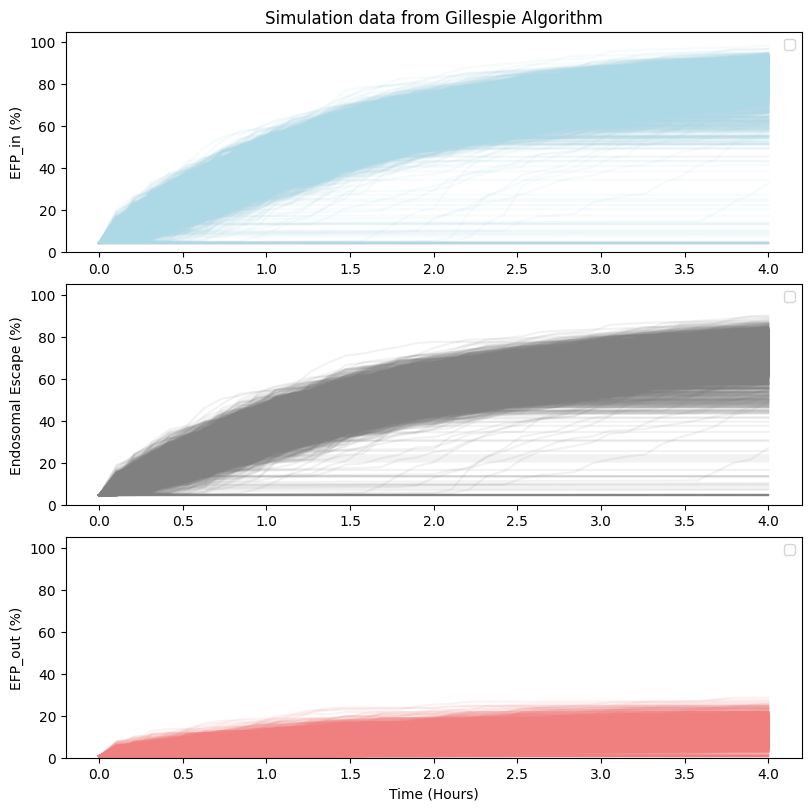

In [99]:
    # Plot the observed and simulated curves
    plt.figure(figsize=(8,8))

    # Plot for C (EFP_in)
    plt.subplot(3, 1, 1)
    for sim in all_simulated_C:
        plt.plot(t_points, sim, color='lightblue', alpha=0.1)
    #plt.plot(t_points, observed_data_C_interp, label="Observed EFP_in", marker='o', color='blue')
    plt.legend(loc="upper left", frameon=True, fontsize=10)
    #plt.xlabel('Time (Hours)')
    plt.ylabel('EFP_in (%)')
    plt.title('Simulation data from Gillespie Algorithm')
    plt.legend()
    plt.ylim(0, 105)

    # Plot for D (Endosomal Escape)
    plt.subplot(3, 1, 2)
    for sim in all_simulated_D:
        plt.plot(t_points, sim, color='gray', alpha=0.1)
    #plt.plot(t_points, observed_data_D_interp, label="Observed Endosomal Escape", marker='o', color='black')
    plt.legend(loc="upper left", frameon=True, fontsize=10)
    #plt.xlabel('Time (Hours)')
    plt.ylabel('Endosomal Escape (%)')
    #plt.title('Simulated vs Observed Endosomal Escape Percentage')
    plt.legend()
    plt.ylim(0, 105)

    # Plot for E (efp_out)
    plt.subplot(3, 1, 3)

    for sim in all_simulated_E:
        plt.plot(t_points, sim, color='lightcoral', alpha=0.1)
    #plt.plot(t_points, observed_data_E_interp, label="Observed EFP_out", marker='o', color='red')
    plt.xlabel('Time (Hours)')
    plt.ylabel('EFP_out (%)')
    #plt.title('Simulated vs Observed EFP_out')
    plt.legend()
    plt.ylim(0, 105)

    # plt.tight_layout()
    plt.show()

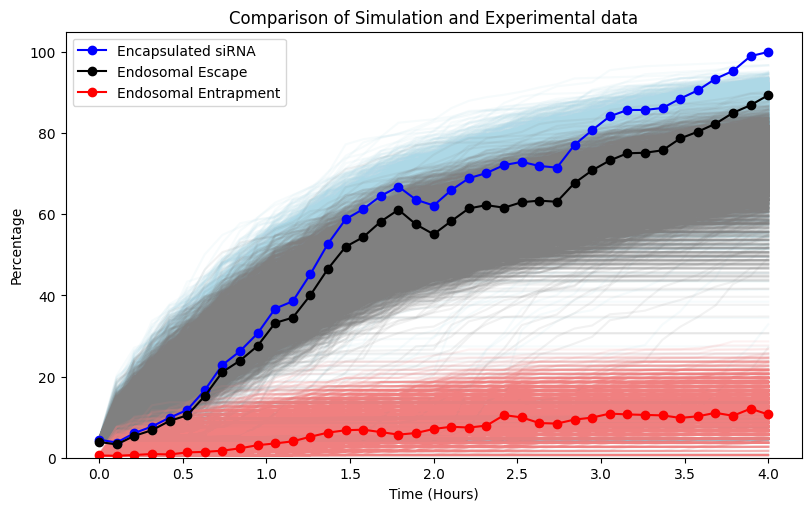

In [102]:
# Plot the observed and simulated curves on one plot
plt.figure(figsize=(8, 5))

# Plot all simulations and observed data on the same plot

# EFP_in
for sim in all_simulated_C:
    plt.plot(t_points, sim, color='lightblue', alpha=0.1)

# Endosomal Escape Percentage
for sim in all_simulated_D:
    plt.plot(t_points, sim, color='gray', alpha=0.1)

# EFP_out
for sim in all_simulated_E:
    plt.plot(t_points, sim, color='lightcoral', alpha=0.1)

plt.plot(t_points, observed_data_C_interp, label="Encapsulated siRNA", marker='o', color='blue')
plt.plot(t_points, observed_data_D_interp, label="Endosomal Escape", marker='o', color='black')
plt.plot(t_points, observed_data_E_interp, label="Endosomal Entrapment", marker='o', color='red')

# Labels and title
plt.xlabel('Time (Hours)')
plt.ylabel('Percentage')
plt.title('Comparison of Simulation and Experimental data')
plt.legend()

# Set the y-axis to 0-105 for all data
plt.ylim(0, 105)

# plt.tight_layout()
plt.show()


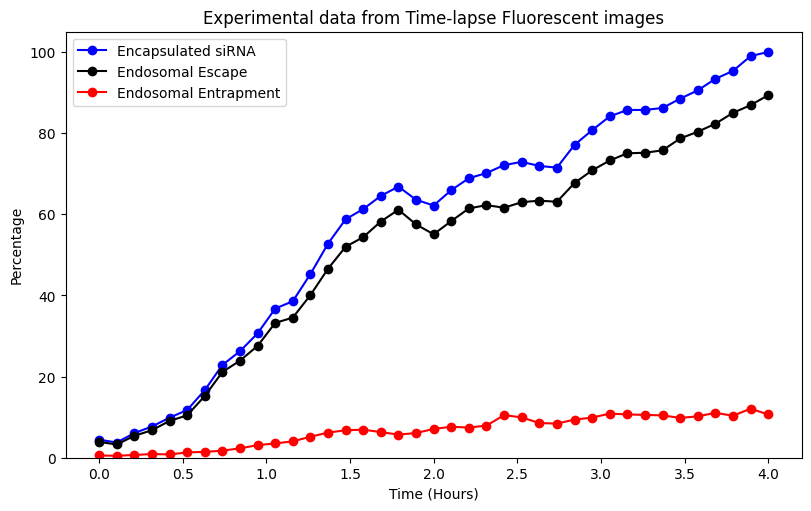

In [101]:
# Plot the observed and simulated curves on one plot
plt.figure(figsize=(8, 5))

plt.plot(t_points, observed_data_C_interp, label="Encapsulated siRNA", marker='o', color='blue')
plt.plot(t_points, observed_data_D_interp, label="Endosomal Escape", marker='o', color='black')
plt.plot(t_points, observed_data_E_interp, label="Endosomal Entrapment", marker='o', color='red')

# Labels and title
plt.xlabel('Time (Hours)')
plt.ylabel('Percentage')
plt.title('Experimental data from Time-lapse Fluorescent images')
plt.legend()

# Set the y-axis to 0-105 for all data
plt.ylim(0, 105)

# plt.tight_layout()
plt.show()
